# Import

In [ ]:
import numpy as np
from google.colab import drive
import pandas as pd
import sys
import scipy.optimize
from scipy.sparse import csr_matrix
import argparse
import pickle
import os
import itertools
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/My Drive/Thesis/data/Coat/test.ascii', 'r') as f:
  file = np.loadtxt(f)

In [ ]:
with open('/content/drive/My Drive/Thesis/data/R3/ydata-ymusic-rating-study-v1_0-train.txt', 'r') as f:
  data_r3 = np.loadtxt(f)

In [ ]:
r3_df = pd.DataFrame(data_r3, columns=["userId", "itemId", "rating"])

In [ ]:
num_users, num_items = 15400, 1000

In [ ]:
n = len(r3_df)

In [ ]:
temp = r3_df.copy()

In [ ]:
temp["count"] = 1

In [ ]:
temp["propensity"] = temp.groupby(["itemId"])['count'].transform(sum) / num_users

In [ ]:
temp = temp[['itemId','propensity']].drop_duplicates().set_index('itemId').to_dict()

In [ ]:
raw_matrix = np.ma.array(file, dtype= int, copy= False, mask= file, fill_value= 0, hard_mask= True)

In [ ]:
num_user, num_item = raw_matrix.shape

In [ ]:
po = n/(num_users*num_items)

In [ ]:
po

0.02024051948051948

In [ ]:
r3_df.groupby(["rating"])["userId"].count()/n

rating
1.0    0.313900
2.0    0.127210
3.0    0.157621
4.0    0.155532
5.0    0.245736
Name: userId, dtype: float64

In [ ]:
r3_df.groupby(["rating"])["userId"].count()

rating
1.0    97844
2.0    39652
3.0    49131
4.0    48480
5.0    76597
Name: userId, dtype: int64

# Metric

In [ ]:
class Jitter:
  def __init__(self, cut_off, num_users, num_items):
      self.jitter = 1e-7 * np.random.standard_normal((num_users, num_items)) #create a dataset with standard normal (mean = 0, std = 1)
      discountParams = 2.0 + np.array(range(num_items), dtype = np.longdouble)
      self.discountParams = np.reciprocal(np.log2(discountParams)) # calculate 1/x
      self.cutOff = min(cut_off, num_items)
      self.discountParams[self.cutOff:] = 0.0

      print("Jitter.init: [DBG]\t (NumUsers, NumItems)", num_users, num_items, "\t Sum DiscountFactors",\
                self.discountParams.sum(dtype = np.longdouble), "\t [Requested/Set] Cut-off:", \
                cut_off, self.cutOff)
  def rank(self, predicted_matrix):
    transformedPredictions = -np.ma.add(predicted_matrix, self.jitter)
    sortedPredictions = np.ma.argsort(transformedPredictions, axis = 1)
    return sortedPredictions
dcgJitter = None              

In [ ]:
def SET_PROPENSITIES(observed_ratings, inverse_propensities= None, verbose = False):
    numObservations = np.ma.count(observed_ratings)
    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems
    inversePropensities = None
    if inverse_propensities is None:
        inversePropensities = np.ones((numUsers, numItems), dtype = np.longdouble) * scale / numObservations
    else:
        inversePropensities = np.array(inverse_propensities, dtype = np.longdouble, copy = True)

    inversePropensities = np.ma.array(inversePropensities, dtype = np.longdouble, copy = False, 
                            mask = np.ma.getmask(observed_ratings), fill_value = 0, hard_mask = True)
 
    if verbose:
        print("Metrics.SET_PROPENSITIES: [LOG]\t NumUsers, NumItems, NumObservations", \
            numUsers, numItems, numObservations)
        print("Metrics.SET_PROPENSITIES: [DBG]\t Sum of observed inverse propensities ", \
            np.ma.sum(inversePropensities, dtype = np.longdouble), \
            "(=? NumUsers * NumItems)", numUsers * numItems)
    return inversePropensities

In [ ]:
SET_PROPENSITIES(raw_matrix, verbose= True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 290 300 82360
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  86999.99999999999998 (=? NumUsers * NumItems) 87000


masked_array(
  data=[[1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        [1.0563380281690140845, --, 1.0563380281690140845, ...,
         1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845],
        [1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        ...,
        [1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        [1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        [1.0563380281690140845, --, 1.0563380281690140845, ...,
         1.0563380281690140845, 1.0563380281690140845,
         1.0563380

In [ ]:
def ITEMWISE_METRICS(observed_ratings, predicted_ratings, inverse_propensities, verbose, mode = 'MSE'):
    delta = np.ma.subtract(predicted_ratings, observed_ratings)
    rectifiedDelta = None
    if mode == 'MSE':
        rectifiedDelta = np.square(delta)
    elif mode == 'MAE':
        rectifiedDelta = np.ma.abs(delta)
    else:
        print("Metrics.ITEMWISE_METRICS: [ERR]\t Unrecognized itemwise metric ", mode)
        sys.exit(0)

    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, verbose)

    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems

    observedError = np.ma.multiply(rectifiedDelta, inversePropensities)
    cumulativeError = np.ma.sum(observedError, dtype = np.longdouble)
    vanillaMetric = cumulativeError / scale
    
    globalNormalizer = np.ma.sum(inversePropensities, dtype = np.longdouble)
    selfNormalizedMetric = cumulativeError / globalNormalizer
    
    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    perUserError = np.ma.sum(observedError, axis = 1, dtype = np.longdouble)
    perUserEstimate = np.ma.divide(perUserError, perUserNormalizer)
    userNormalizedMetric = np.ma.sum(perUserEstimate, dtype = np.longdouble) / numUsers

    perItemNormalizer = np.ma.sum(inversePropensities, axis = 0, dtype = np.longdouble)
    perItemNormalizer = np.ma.masked_less_equal(perItemNormalizer, 0.0, copy = False)

    perItemError = np.ma.sum(observedError, axis = 0, dtype = np.longdouble)
    perItemEstimate = np.ma.divide(perItemError, perItemNormalizer)
    itemNormalizedMetric = np.ma.sum(perItemEstimate, dtype = np.longdouble) / numItems
   
    if verbose:
        print("Metrics.ITEMWISE_METRICS: [LOG]\t Vanilla, SelfNormalized, UserNormalized, ItemNormalized", \
            vanillaMetric, selfNormalizedMetric, userNormalizedMetric, itemNormalizedMetric)

    return vanillaMetric, selfNormalizedMetric, userNormalizedMetric, itemNormalizedMetric

In [ ]:
def MSE(observed_ratings, predicted_ratings, inverse_propensities, verbose = False):
    return ITEMWISE_METRICS(observed_ratings, predicted_ratings, inverse_propensities, verbose, mode = 'MSE')


def MAE(observed_ratings, predicted_ratings, inverse_propensities, verbose = False):
    return ITEMWISE_METRICS(observed_ratings, predicted_ratings, inverse_propensities, verbose, mode = 'MAE')

In [ ]:
def DCG(observed_ratings, predicted_ratings, inverse_propensities, cut_off = 50, verbose = False):
    global dcgJitter
    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems

    if dcgJitter is None or dcgJitter.cutOff != cut_off:
        dcgJitter = Jitter(cut_off, numUsers, numItems)
 
    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, verbose)
    
    predictedRankings = dcgJitter.rank(predicted_ratings)
    weightedGain = np.ma.multiply(observed_ratings, inversePropensities)
 
    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    staticIndices = np.ogrid[0:numUsers, 0:numItems]
    rankedGains = weightedGain[staticIndices[0], predictedRankings]
    perUserDCG = np.ma.dot(rankedGains, dcgJitter.discountParams)

    dcgValue = np.ma.sum(perUserDCG, dtype = np.longdouble) / numUsers
    snDCGValue = dcgValue * scale / np.ma.sum(inversePropensities, dtype = np.longdouble)

    perUserNormalizedEstimates = np.ma.divide(perUserDCG, perUserNormalizer)
    uDCGValue = numItems * np.ma.sum(perUserNormalizedEstimates, dtype = np.longdouble) / numUsers
    
    if verbose:
        print("Metrics.DCG: [LOG]\t DCG, SN-DCG, UN-DCG, IN-DCG", dcgValue, snDCGValue, uDCGValue, 0.0)
    return dcgValue, snDCGValue, uDCGValue, 0.0

In [ ]:
def CG(observed_ratings, selected_items, inverse_propensities, verbose = False):
    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, verbose)

    clippedSelections = np.clip(selected_items, 0, 1)
    weightedGain = np.ma.multiply(observed_ratings, inversePropensities)
    cumulativeGain = np.ma.multiply(weightedGain, clippedSelections)
    
    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems

    globalGain = np.ma.sum(cumulativeGain, dtype = np.longdouble)
    globalNormalizer = np.ma.sum(inversePropensities, dtype = np.longdouble)

    cg = globalGain / numUsers
    snCG = numItems * globalGain / globalNormalizer

    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    perUserGain = np.ma.sum(cumulativeGain, axis = 1, dtype = np.longdouble)
    perUserEstimate = np.ma.divide(perUserGain, perUserNormalizer)
    unCG = numItems * np.ma.sum(perUserEstimate, dtype = np.longdouble) / numUsers

    perItemNormalizer = np.ma.sum(inversePropensities, axis = 0, dtype = np.longdouble)
    perItemNormalizer = np.ma.masked_less_equal(perItemNormalizer, 0.0, copy = False)

    perItemGain = np.ma.sum(cumulativeGain, axis = 0, dtype = np.longdouble)
    perItemEstimate = np.ma.divide(perItemGain, perItemNormalizer)
    inCG = np.ma.sum(perItemEstimate, dtype = np.longdouble)
       
    if verbose:
        print("Metrics.CG: [LOG]\t CG, SN-CG, UN-CG, IN-CG", cg, snCG, unCG, inCG)
    return cg, snCG, unCG, inCG


In [ ]:
x = 1e-7 * np.random.standard_normal((5, 4))

In [ ]:
y = np.array(range(20)).reshape(5,4)

In [ ]:
shape = (5,3)
a = np.random.randint(0,5, size=shape)
b = np.random.randint(0,5, size=shape)

In [ ]:
a

array([[2, 3, 2],
       [0, 0, 2],
       [0, 4, 3],
       [1, 0, 2],
       [0, 4, 2]])

In [ ]:
b

array([[1, 2, 3],
       [3, 4, 1],
       [1, 2, 1],
       [0, 0, 2],
       [1, 2, 3]])

In [ ]:
inversePropensities = np.random.random(shape)

In [ ]:
inversePropensities

array([[0.34589948, 0.96260804, 0.07418004],
       [0.47904902, 0.82695578, 0.29345579],
       [0.8059673 , 0.72291388, 0.14104004],
       [0.74031159, 0.21053303, 0.47947639],
       [0.37425934, 0.62474694, 0.00445402]])

In [ ]:
obs = np.random.random(shape)
obs

array([[0.644326  , 0.27092089, 0.80512596],
       [0.27292091, 0.00734508, 0.39936607],
       [0.05657354, 0.86652208, 0.67499708],
       [0.98023988, 0.49930861, 0.89377254],
       [0.19875959, 0.70943231, 0.49424999]])

In [ ]:
obs = obs < inversePropensities
obs

array([[False,  True, False],
       [ True,  True, False],
       [ True, False, False],
       [False, False, False],
       [ True, False, False]])

In [ ]:
inversePropensities = np.reciprocal(inversePropensities)
inversePropensities

array([[  2.8910133 ,   1.03884443,  13.48071572],
       [  2.08746903,   1.2092545 ,   3.40766836],
       [  1.24074513,   1.38329063,   7.09018515],
       [  1.35078259,   4.74984841,   2.08560844],
       [  2.67194402,   1.60064811, 224.51641059]])

In [ ]:
observed_a = np.ma.array(a, dtype = np.longdouble, copy = True, 
                        mask = np.logical_not(obs), fill_value = 0, hard_mask = True)

In [ ]:
observed_a

masked_array(
  data=[[--, 3.0, --],
        [0.0, 0.0, --],
        [0.0, --, --],
        [--, --, --],
        [0.0, --, --]],
  mask=[[ True, False,  True],
        [False, False,  True],
        [False,  True,  True],
        [ True,  True,  True],
        [False,  True,  True]],
  fill_value=0.0,
  dtype=float128)

In [ ]:
MSE(observed_a, b, inversePropensities, verbose = True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 5
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  8.248257107510632569 (=? NumUsers * NumItems) 15
Metrics.ITEMWISE_METRICS: [LOG]	 Vanilla, SelfNormalized, UserNormalized, ItemNormalized 2.8724551235177669284 5.223749246799404774 2.9135269273997004102 4.2839108573572456623


(2.8724551235177669284,
 5.223749246799404774,
 2.9135269273997004102,
 4.2839108573572456623)

In [ ]:
MAE(observed_a, b, inversePropensities, verbose = True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 5
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  8.248257107510632569 (=? NumUsers * NumItems) 15
Metrics.ITEMWISE_METRICS: [LOG]	 Vanilla, SelfNormalized, UserNormalized, ItemNormalized 1.0700639111147994597 1.9459818550159447865 1.27336098962852863 1.4365024825279933456


(1.0700639111147994597,
 1.9459818550159447865,
 1.27336098962852863,
 1.4365024825279933456)

In [ ]:
DCG(observed_a, b, inversePropensities, cut_off = 50, verbose = True)

Jitter.init: [DBG]	 (NumUsers, NumItems) 5 3 	 Sum DiscountFactors 2.1309297535714574372 	 [Requested/Set] Cut-off: 50 3
Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 5
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  8.248257107510632569 (=? NumUsers * NumItems) 15
Metrics.DCG: [LOG]	 DCG, SN-DCG, UN-DCG, IN-DCG 0.39326271775665822063 0.71517421068003112926 1.1356735564286233868 0.0


(0.39326271775665822063, 0.71517421068003112926, 1.1356735564286233868, 0.0)

In [ ]:
CG(observed_a, b, inversePropensities, verbose = True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 5
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  8.248257107510632569 (=? NumUsers * NumItems) 15
Metrics.CG: [LOG]	 CG, SN-CG, UN-CG, IN-CG 0.62330666057599124483 1.1335243054107011416 1.8 1.3862972182641831612


(0.62330666057599124483, 1.1335243054107011416, 1.8, 1.3862972182641831612)

# Matrix Fatorization

In [ ]:
def PREDICTED_SCORES(user_vectors, item_vectors, user_biases, item_biases, global_bias, use_bias = True):
    rawScores = np.dot(user_vectors, item_vectors.T)
    if use_bias:
        biasedScores = rawScores + user_biases[:,None] + item_biases[None,:] + global_bias
        return biasedScores
    else:
        return rawScores

In [ ]:
def GENERATE_MATRIX(observed_ratings, inverse_propensities, l2_regularization, num_dimensions, normalization,
        bias_mode = 'Regularized', mode = 'MSE', start_vec = None, verbose = False):

    metricMode = None
    if mode == 'MSE':
        metricMode = 1
    elif mode == 'MAE':
        metricMode = 2
    else:
        print("MF.GENERATE_MATRIX: [ERR]\t Metric not supported:", mode)
        sys.exit(0)

    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, False)

    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems
    numObservations = np.ma.count(observed_ratings)

    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    perItemNormalizer = np.ma.sum(inversePropensities, axis = 0, dtype = np.longdouble)
    perItemNormalizer = np.ma.masked_less_equal(perItemNormalizer, 0.0, copy = False)

    globalNormalizer = np.ma.sum(inversePropensities, dtype = np.longdouble)

    normalizedPropensities = None
    if normalization == 'Vanilla':
        normalizedPropensities = inversePropensities
    elif normalization == 'SelfNormalized':
        normalizedPropensities = scale * np.ma.divide(inversePropensities, globalNormalizer)
    elif normalization == 'UserNormalized':
        normalizedPropensities = numItems * np.ma.divide(inversePropensities, perUserNormalizer[:, None])
    elif normalization == 'ItemNormalized':
        normalizedPropensities = numUsers * np.ma.divide(inversePropensities, perItemNormalizer[None, :])
    else:
        print("MF.GENERATE_MATRIX: [ERR]\t Normalization not supported:", normalization)
        sys.exit(0)
    
    useBias = None
    regularizeBias = None
    if bias_mode == 'None':
        useBias = False
        regularizeBias = False
    elif bias_mode == 'Regularized':
        useBias = True
        regularizeBias = True
    elif bias_mode == 'Free':
        useBias = True
        regularizeBias = False
    else:
        print("MF.GENERATE_MATRIX: [ERR]\t Bias mode not supported:", bias_mode)
        sys.exit(0)

    if verbose:
        print("MF.GENERATE_MATRIX: [LOG]\t Lamda:", l2_regularization, "\t NumDims:", num_dimensions,\
            "\t Normalization:", normalization, "\t Metric:", mode, "\t BiasMode:", bias_mode)

    normalizedPropensities = np.ma.filled(normalizedPropensities, 0.0)
    observedRatings = np.ma.filled(observed_ratings, 0)
    
    def Mat2Vec(user_vectors, item_vectors, user_biases, item_biases, global_bias):
        allUserParams = np.concatenate((user_vectors, user_biases[:,None]), axis = 1)
        allItemParams = np.concatenate((item_vectors, item_biases[:,None]), axis = 1)
        
        allParams = np.concatenate((allUserParams, allItemParams), axis = 0)
        paramVector = np.reshape(allParams, (numUsers + numItems)*(num_dimensions + 1))
        paramVector = np.concatenate((paramVector, [global_bias]))
        return paramVector.astype(float)
        
    def Vec2Mat(paramVector):
        globalBias = paramVector[-1]
        remainingParams = paramVector[:-1]
        allParams = np.reshape(remainingParams, (numUsers + numItems, num_dimensions + 1))
        allUserParams = allParams[0:numUsers,:]
        allItemParams = allParams[numUsers:, :]
        
        userVectors = (allUserParams[:,0:-1]).astype(np.longdouble)
        userBiases = (allUserParams[:,-1]).astype(np.longdouble)
        
        itemVectors = (allItemParams[:,0:-1]).astype(np.longdouble)
        itemBiases = (allItemParams[:,-1]).astype(np.longdouble)
        return userVectors, itemVectors, userBiases, itemBiases, globalBias
    
    def Objective(paramVector):
        userVectors, itemVectors, userBiases, itemBiases, globalBias = Vec2Mat(paramVector)
        biasedScores = PREDICTED_SCORES(userVectors, itemVectors, userBiases, itemBiases, globalBias, useBias)

        delta = np.subtract(biasedScores, observedRatings)
        loss = None
        if metricMode == 1:
            loss = np.square(delta)
        elif metricMode == 2:
            loss = np.abs(delta)
        else:
            sys.exit(0)

        weightedLoss = np.multiply(loss, normalizedPropensities)
        objective = np.sum(weightedLoss, dtype = np.longdouble)

        gradientMultiplier = None
        if metricMode == 1:
            gradientMultiplier = np.multiply(normalizedPropensities, 2 * delta)
        elif metricMode == 2:
            gradientMultiplier = np.zeros(np.shape(delta), dtype = np.int)
            gradientMultiplier[delta > 0] = 1
            gradientMultiplier[delta < 0] = -1
            gradientMultiplier = np.multiply(normalizedPropensities, gradientMultiplier)
        else:
            sys.exit(0)

        userVGradient = np.dot(gradientMultiplier, itemVectors)
        itemVGradient = np.dot(gradientMultiplier.T, userVectors)

        userBGradient = None
        itemBGradient = None
        globalBGradient = None
        if useBias:
            userBGradient = np.sum(gradientMultiplier, axis = 1, dtype = np.longdouble)
            itemBGradient = np.sum(gradientMultiplier, axis = 0, dtype = np.longdouble)
            globalBGradient = np.sum(gradientMultiplier, dtype = np.longdouble)
        else:
            userBGradient = np.zeros(np.shape(userBiases), dtype = np.longdouble)
            itemBGradient = np.zeros(np.shape(itemBiases), dtype = np.longdouble)
            globalBGradient = 0.0

        if l2_regularization > 0:
            scaledPenalty = 1.0 * l2_regularization * scale / (numUsers + numItems)
            if regularizeBias:
                scaledPenalty /= (num_dimensions + 1)
            else:
                scaledPenalty /= num_dimensions

            userVGradient += 2 * scaledPenalty * userVectors
            itemVGradient += 2 * scaledPenalty * itemVectors
          
            objective += scaledPenalty * np.sum(np.square(userVectors), dtype = np.longdouble)
            objective += scaledPenalty * np.sum(np.square(itemVectors), dtype = np.longdouble)
 
            if regularizeBias:
                userBGradient += 2 * scaledPenalty * userBiases
                itemBGradient += 2 * scaledPenalty * itemBiases
                globalBGradient += 2 * scaledPenalty * globalBias
                objective += scaledPenalty * np.sum(np.square(userBiases), dtype = np.longdouble)
                objective += scaledPenalty * np.sum(np.square(itemBiases), dtype = np.longdouble)
                objective += scaledPenalty * globalBias * globalBias
            
        gradient = Mat2Vec(userVGradient, itemVGradient, userBGradient, itemBGradient, globalBGradient)

        if verbose:
            print(".")
            sys.stdout.flush()
        
        return objective, gradient
    
    def ObjectiveOnly(paramVector):
        objective, gradient = Objective(paramVector)
        return objective
    def GradientOnly(paramVector):
        objective, gradient = Objective(paramVector)
        return gradient
    
    userVectorsInit = None
    itemVectorsInit = None
    userBiasesInit = None
    itemBiasesInit = None
    globalBiasInit = None
    if start_vec is None:
        userVectorsInit = np.random.standard_normal((numUsers, num_dimensions))
        itemVectorsInit = np.random.standard_normal((numItems, num_dimensions))
        userBiasesInit = np.zeros(numUsers, dtype = float)
        itemBiasesInit = np.zeros(numItems, dtype = float)
        globalBiasInit = 0
    else:
        userVectorsInit = start_vec[0]
        itemVectorsInit = start_vec[1]
        userBiasesInit = start_vec[2]
        itemBiasesInit = start_vec[3]
        globalBiasInit = start_vec[4]
    
    startVector = Mat2Vec(userVectorsInit, itemVectorsInit, userBiasesInit, itemBiasesInit, globalBiasInit)

    if verbose:
        print("MF.GENERATE_MATRIX: [DBG]\t Checking gradients")
        print(scipy.optimize.check_grad(ObjectiveOnly, GradientOnly, startVector))

    ops = {'maxiter': 2000, 'disp': False, 'gtol': 1e-5,\
            'ftol': 1e-5, 'maxcor': 50}

    result = scipy.optimize.minimize(fun = Objective, x0 = startVector,
                    method = 'L-BFGS-B', jac = True, tol = 1e-5, options = ops)
    
    if verbose:
        print("MF.GENERATE_MATRIX: [DBG]\t Optimization result:", result['message'])
        sys.stdout.flush()

    return Vec2Mat(result['x'])
 

In [ ]:
rows = [2,1,4,3,0,4,3]
cols = [0,2,1,1,0,0,0]
vals = [1,2,3,4,5,4,5]

In [ ]:
checkY = scipy.sparse.coo_matrix((vals, (rows,cols)), dtype = int)

In [ ]:
checkY = checkY.toarray()

In [ ]:
checkY = np.ma.array(checkY, dtype = int, mask = checkY <= 0, hard_mask = True, copy = False)

In [ ]:
checkY

masked_array(
  data=[[5, --, --],
        [--, --, 2],
        [1, --, --],
        [5, 4, --],
        [4, 3, --]],
  mask=[[False,  True,  True],
        [ True,  True, False],
        [False,  True,  True],
        [False, False,  True],
        [False, False,  True]],
  fill_value=999999)

In [ ]:
randomPropensities = np.random.random(size = np.shape(checkY))
randomInvPropensities = np.reciprocal(randomPropensities)

In [ ]:
randomPropensities

array([[0.5686899 , 0.41964654, 0.41321171],
       [0.37407741, 0.04218534, 0.12171687],
       [0.75696396, 0.71829296, 0.8228237 ],
       [0.80943968, 0.69070218, 0.53188129],
       [0.23201707, 0.18349732, 0.42793752]])

In [ ]:
randomInvPropensities

array([[ 1.75842757,  2.38295779,  2.42006692],
       [ 2.67324352, 23.7049172 ,  8.21578823],
       [ 1.32106686,  1.39218961,  1.21532717],
       [ 1.2354225 ,  1.447802  ,  1.88011879],
       [ 4.31002772,  5.44967097,  2.33678971]])

In [ ]:
userVectors, itemVectors, userBiases, itemBiases, globalBias = GENERATE_MATRIX(checkY, None, 1.0, 5, 'Vanilla',
                                                'Regularized', 'MSE', None, verbose = True)

MF.GENERATE_MATRIX: [LOG]	 Lamda: 1.0 	 NumDims: 5 	 Normalization: Vanilla 	 Metric: MSE 	 BiasMode: Regularized
MF.GENERATE_MATRIX: [DBG]	 Checking gradients
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
4.951853743165111e-07
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
MF.GENERATE_MATRIX: [DBG]	 Optimization result: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [ ]:
userVectors, itemVectors, userBiases, itemBiases, globalBias

(array([[-2.74164069e-01, -5.28271005e-01, -6.38794814e-01,
          4.52016636e-01,  3.15020807e-01],
        [ 1.14588174e-03,  2.02177584e-03,  1.38673868e-03,
          1.42629040e-03,  6.30949033e-05],
        [ 1.96131950e-01,  3.64122281e-01,  4.46304166e-01,
         -3.16613959e-01, -2.17411748e-01],
        [-2.18074303e-01, -4.27548122e-01, -4.98877729e-01,
          3.61997072e-01,  2.60593000e-01],
        [-1.72373581e-01, -3.18978656e-01, -4.02046137e-01,
          2.78503592e-01,  1.95882307e-01]], dtype=float128),
 array([[-4.09235092e-01, -7.79137156e-01, -9.55831519e-01,
          6.72402040e-01,  4.68357806e-01],
        [-1.44701590e-01, -2.94106962e-01, -3.32542119e-01,
          2.44382113e-01,  1.78488176e-01],
        [-7.46207687e-04, -2.66103728e-03, -1.30354573e-03,
         -1.24306327e-03,  4.96280022e-04]], dtype=float128),
 array([ 0.67598896,  0.13397214, -0.46636028,  1.0607605 ,  0.3075728 ],
       dtype=float128),
 array([0.92780219, 0.65015979, 0.

In [ ]:
userVectors.shape

(5, 5)

In [ ]:
itemVectors.shape

(3, 5)

In [ ]:
np.dot(userVectors, itemVectors.T)

array([[ 1.58585271e+00,  5.74158609e-01,  2.03748368e-03],
       [-2.38107267e-03, -8.61756724e-04, -9.78442040e-06],
       [-1.10527523e+00, -4.00066651e-01, -1.41140195e-03],
       [ 1.26466368e+00,  4.58176814e-01,  1.63010198e-03],
       [ 9.82367201e-01,  3.55477821e-01,  1.25254100e-03]],
      dtype=float128)

In [ ]:
completeScores = PREDICTED_SCORES(userVectors, itemVectors, userBiases, itemBiases, globalBias, True)

In [ ]:
completeScores

array([[4.90157797, 3.61224147, 2.5239327 ],
       [2.77132737, 2.49520429, 1.97986862],
       [1.0681008 , 1.49566697, 1.37813457],
       [4.96516048, 3.88103122, 2.90829686],
       [3.92967631, 3.02514453, 2.1547316 ]], dtype=float128)

In [ ]:
def MF_TRAIN(params, train_observations, inv_propensities, normalization, metric, start_vector):
    retVal = None
    actualStart = None
    if start_vector is not None:
        actualStart = (start_vector[0][:,0:params[1]], start_vector[1][:,0:params[1]],
                        start_vector[2], start_vector[3], start_vector[4])

    tempInvPropensities = None
    if inv_propensities is not None:
        tempInvPropensities = (4.0 / 3.0) * inv_propensities
        if params[2] >= 0:
            tempInvPropensities = np.clip(tempInvPropensities, a_min = 0, a_max = params[2])

    retVal = GENERATE_MATRIX(train_observations, tempInvPropensities, params[0], 
                                params[1], normalization, bias_mode = params[3], mode = metric, 
                                start_vec = actualStart, verbose = False)

    return retVal

In [ ]:
def FINAL_TRAIN(approach_tuple, metric, observations, start_vector):
    invP = approach_tuple[1]
    normN = approach_tuple[2]
    bestLambda = approach_tuple[3][0]
    bestDims = approach_tuple[3][1]
    bestClip = approach_tuple[3][2]
    bestBias = approach_tuple[3][3]
    actualStart = None
    if start_vector is not None:
        actualStart = (start_vector[0][:,0:bestDims], start_vector[1][:,0:bestDims],
                        start_vector[2], start_vector[3], start_vector[4])

    tempInvP = None
    if bestClip < 0 or invP is None:
        tempInvP = invP
    else:
        tempInvP = np.clip(invP, a_min = 0, a_max = bestClip)

    retVal = GENERATE_MATRIX(observations, tempInvP, bestLambda, bestDims, normN, bias_mode = bestBias,
                        mode = metric, start_vec = actualStart)

    return retVal

In [ ]:
def INIT_PARAMS(partial_observations, num_dimensions):
    averageObservedRating = np.ma.mean(partial_observations, dtype = np.longdouble)
    completeRatings = np.ma.filled(partial_observations.astype(float), averageObservedRating)
    numUsers, numItems = np.shape(partial_observations)

    u,s,vt = scipy.sparse.linalg.svds(completeRatings, k = num_dimensions, ncv = 50, tol = 1e-7, which = 'LM', 
                        v0 = None, maxiter = 2000, return_singular_vectors = True)
            
    startTuple = (u, np.transpose(np.multiply(vt, s[:,None])), 
                     np.zeros(numUsers, dtype = np.longdouble), 
                     np.zeros(numItems, dtype = np.longdouble), 
                     averageObservedRating)
    return startTuple 

In [ ]:
def TRAIN_HELPER(approach, gold_inv_propensities, nb_inv_propensities):
    invP = None
    if approach == 'Naive':
        invP = None
    elif approach.startswith('Gold'):
        invP = gold_inv_propensities
    elif approach.startswith('NB'):
        invP = nb_inv_propensities
    else:
        print("TRAIN_HELPER: [ERR] Unrecognized approach", approach)
        sys.exit(0)

    normN = None
    if approach == 'Naive' or approach.endswith('-IPS'):
        normN = 'Vanilla'
    elif approach.endswith('-SNIPS'):
        normN = 'SelfNormalized'
    elif approach.endswith('-UNIPS'):
        normN = 'UserNormalized'
    elif approach.endswith('-INIPS'):
        normN = 'ItemNormalized'
    else:
        print("TRAIN_HELPER: [ERR] Unrecognized approach", approach)
        sys.exit(0)
        
    return invP, normN   

In [ ]:
def learn(data, logger, lambdas=None, seed=None, numDims=None, approach=None, metric=None, raw_metric=None,
          output_name=None, propensities_desc=None):
    clipVals = [-1]
    biasModes = ['Free', 'Regularized']
    np.random.seed(seed)

    numBiasModes = len(biasModes)
    numLambdas = len(lambdas)
    numDimSettings = len(numDims)
    numClipSettings = len(clipVals)
    numParamSettings = numLambdas * numDimSettings * numClipSettings * numBiasModes

    paramSettings = list(itertools.product(lambdas, numDims, clipVals, biasModes))
    numApproaches = 1

    selfMatrix = data.train

    logger.log("Starting learning...")
    logger.log("\t-metric: " + raw_metric, 2)
    logger.log("\t-lambda values: " + str(lambdas), 2)
    logger.log("\t-dimension values: " + str(numDims), 2)
    logger.log("\t-propensity scoring method: " + propensities_desc)
    if data.propensities is not None:
        invP = np.reciprocal(data.propensities)
        invP = np.ma.array(invP, dtype=np.longdouble, copy=False,
                              mask=np.ma.getmask(selfMatrix), fill_value=0, hard_mask=True)
    else:
        invP = None

    foldScores = np.zeros((numApproaches, 4, numParamSettings), dtype=float)

    observationIndices = np.ma.nonzero(selfMatrix)
    numObservations = np.ma.count(selfMatrix)

    shuffleIndices = np.random.permutation(numObservations)
    fractionObservations = int(numObservations / 4)
    firstFold = shuffleIndices[:fractionObservations]
    secondFold = shuffleIndices[fractionObservations:2 * fractionObservations]
    thirdFold = shuffleIndices[2 * fractionObservations:3 * fractionObservations]
    fourthFold = shuffleIndices[3 * fractionObservations:]

    logger.log("Split %d observations into folds. Fold sizes: %s" %
               (len(shuffleIndices), str([len(firstFold), len(secondFold), len(thirdFold), len(fourthFold)])),
               2)

    for fold in range(4):
        logger.log("Learning on fold %d " % fold)
        trainObservations = np.ma.copy(selfMatrix)
        testObservations = np.ma.copy(selfMatrix)

        if fold == 0:
            trainObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 1:
            trainObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 2:
            trainObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 3:
            trainObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

        # Get starting params by SVD
        startTuple = INIT_PARAMS(trainObservations, 40)
        normN = "Vanilla"
        approachIndex = 0

        modelsPerLambda = Parallel(n_jobs=-1, verbose=0)(delayed(MF_TRAIN)(param,
                                                                                 trainObservations, invP, normN,
                                                                                 raw_metric, startTuple)
                                                         for param in paramSettings)

        for lambdaIndex, eachModel in enumerate(modelsPerLambda):
            selectedBiasMode = paramSettings[lambdaIndex][3]
            selectedBias = True
            if selectedBiasMode == 'None':
                selectedBias = False
            predictedY = PREDICTED_SCORES(eachModel[0], eachModel[1],
                                             eachModel[2], eachModel[3], eachModel[4], use_bias=selectedBias)

            score = None
            if invP is not None:
                score = metric(testObservations, predictedY, 4.0 * invP)
            else:
                score = metric(testObservations, predictedY, invP)
            score = score[0]
            foldScores[approachIndex, fold, lambdaIndex] = score

            logger.log("\tLambda/NumDims: " + str(paramSettings[lambdaIndex]) +
                       ", Test Fold Score: " + str(score), 2)

    eventualApproachParams = []

    normN = "Vanilla"
    approachIndex = 0
    approachScores = foldScores[approachIndex, :, :]
    allFoldScores = approachScores.sum(axis=0, dtype=float)
    bestLambdaIndex = np.argmin(allFoldScores)
    bestLambda = paramSettings[bestLambdaIndex]
    logger.log("Retraining with best hyperparameter values: " + str(bestLambda))
    logger.log("Chosen from average cross-validation performance:", 2)
    for everyLambdaIndex, everyLambda in enumerate(paramSettings):
        logger.log("\t" + str(everyLambda) + ": " +  str(allFoldScores[everyLambdaIndex]), 2)
    eventualApproachParams.append((approach, invP, normN, bestLambda))

    finalModels = Parallel(n_jobs=-1, verbose=0)(delayed(FINAL_TRAIN)(approachTup,
                                                                            raw_metric, selfMatrix, startTuple)
                                                 for approachTup in eventualApproachParams)

    for approachID, approachTuple in enumerate(eventualApproachParams):
        resultTuple = finalModels[approachID]
        finalBiasMode = approachTuple[3][3]
        finalBias = True
        if finalBiasMode == 'None':
            finalBias = False

        predictedY = PREDICTED_SCORES(resultTuple[0], resultTuple[1],
                                         resultTuple[2], resultTuple[3], resultTuple[4], use_bias=finalBias)
        np.savetxt(output_name, predictedY)
        logger.log("Done.")


# Experiment

## Code


In [ ]:
def learn(data, logger, lambdas=None, seed=None, numDims=None, approach=None, metric=None, raw_metric=None,
          output_name=None, propensities_desc=None):
    clipVals = [-1]
    #biasModes = ['Free', 'Regularized']
    biasModes = ['Regularized']
    np.random.seed(seed)

    numBiasModes = len(biasModes)
    numLambdas = len(lambdas)
    numDimSettings = len(numDims)
    numClipSettings = len(clipVals)
    numParamSettings = numLambdas * numDimSettings * numClipSettings * numBiasModes

    paramSettings = list(itertools.product(lambdas, numDims, clipVals, biasModes))
    numApproaches = 1

    selfMatrix = data.train

    logger.log("Starting learning...")
    logger.log("\t-metric: " + raw_metric, 2)
    logger.log("\t-lambda values: " + str(lambdas), 2)
    logger.log("\t-dimension values: " + str(numDims), 2)
    logger.log("\t-propensity scoring method: " + propensities_desc)
    if data.propensities is not None:
        invP = np.reciprocal(data.propensities)
        invP = np.ma.array(invP, dtype=np.longdouble, copy=False,
                              mask=np.ma.getmask(selfMatrix), fill_value=0, hard_mask=True)
    else:
        invP = None

    foldScores = np.zeros((numApproaches, 4, numParamSettings), dtype=float)

    observationIndices = np.ma.nonzero(selfMatrix)
    numObservations = np.ma.count(selfMatrix)

    shuffleIndices = np.random.permutation(numObservations)
    fractionObservations = int(numObservations / 4)
    firstFold = shuffleIndices[:fractionObservations]
    secondFold = shuffleIndices[fractionObservations:2 * fractionObservations]
    thirdFold = shuffleIndices[2 * fractionObservations:3 * fractionObservations]
    fourthFold = shuffleIndices[3 * fractionObservations:]

    logger.log("Split %d observations into folds. Fold sizes: %s" %
               (len(shuffleIndices), str([len(firstFold), len(secondFold), len(thirdFold), len(fourthFold)])),
               2)

    for fold in range(4):
        logger.log("Learning on fold %d " % fold)
        trainObservations = np.ma.copy(selfMatrix)
        testObservations = np.ma.copy(selfMatrix)

        if fold == 0:
            trainObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 1:
            trainObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 2:
            trainObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 3:
            trainObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

        # Get starting params by SVD
        startTuple = INIT_PARAMS(trainObservations, 40)
        normN = "Vanilla"
        approachIndex = 0

        modelsPerLambda = Parallel(n_jobs=-1, verbose=0)(delayed(MF_TRAIN)(param,
                                                                                 trainObservations, invP, normN,
                                                                                 raw_metric, startTuple)
                                                         for param in paramSettings)

        for lambdaIndex, eachModel in enumerate(modelsPerLambda):
            selectedBiasMode = paramSettings[lambdaIndex][3]
            selectedBias = True
            if selectedBiasMode == 'None':
                selectedBias = False
            predictedY = PREDICTED_SCORES(eachModel[0], eachModel[1],
                                             eachModel[2], eachModel[3], eachModel[4], use_bias=selectedBias)

            score = None
            if invP is not None:
                score = metric(testObservations, predictedY, 4.0 * invP)
            else:
                score = metric(testObservations, predictedY, invP)
            score = score[0]
            foldScores[approachIndex, fold, lambdaIndex] = score

            logger.log("\tLambda/NumDims: " + str(paramSettings[lambdaIndex]) +
                       ", Test Fold Score: " + str(score), 2)

    eventualApproachParams = []

    normN = "Vanilla"
    approachIndex = 0
    approachScores = foldScores[approachIndex, :, :]
    allFoldScores = approachScores.sum(axis=0, dtype=float)
    bestLambdaIndex = np.argmin(allFoldScores)
    bestLambda = paramSettings[bestLambdaIndex]
    logger.log("Retraining with best hyperparameter values: " + str(bestLambda))
    logger.log("Chosen from average cross-validation performance:", 2)
    for everyLambdaIndex, everyLambda in enumerate(paramSettings):
        logger.log("\t" + str(everyLambda) + ": " +  str(allFoldScores[everyLambdaIndex]/4), 2)
    eventualApproachParams.append((approach, invP, normN, bestLambda))

    finalModels = Parallel(n_jobs=-1, verbose=0)(delayed(FINAL_TRAIN)(approachTup,
                                                                            raw_metric, selfMatrix, startTuple)
                                                 for approachTup in eventualApproachParams)

    for approachID, approachTuple in enumerate(eventualApproachParams):
        resultTuple = finalModels[approachID]
        finalBiasMode = approachTuple[3][3]
        finalBias = True
        if finalBiasMode == 'None':
            finalBias = False

        predictedY = PREDICTED_SCORES(resultTuple[0], resultTuple[1],
                                         resultTuple[2], resultTuple[3], resultTuple[4], use_bias=finalBias)
        np.savetxt(output_name, predictedY)
        logger.log("Done.")
    return predictedY

In [ ]:
class Files(object):
    def __init__(self, train, propensities):
        self.train = train
        self.propensities = propensities

In [ ]:
class Logger(object):
    def __init__(self, verbosity_level=1):
        self._verbosity_level = verbosity_level

    def log(self, message, level=1):
        if level <= self._verbosity_level:
            print(message)
            sys.stdout.flush()

In [ ]:
def load_ratings(filename):
    try:
        raw_matrix = np.loadtxt(filename)
        return np.ma.array(raw_matrix, dtype=int, copy=False,
                              mask=raw_matrix <= 0, fill_value=0, hard_mask=True)
    except:
        print("Error: Could not load rating file '%s'") % filename
        exit()

In [ ]:
def load_propensities(filename):
    try:
        return np.loadtxt(filename)
    except:
        print("Error: Could not load propensities.")
        exit()


In [ ]:
def check_writeable(filename):
    try:
        with open(filename, "wb") as f:
            pass
        os.remove(filename)
        return True, ""
    except IOError:
        print("Error: Could not open file '%s' for writing") % filename
        exit()

In [ ]:
def statistic_rating(rating_matrix):
  flatten = np.append(rating_matrix.flatten(), 0)
  num_rating = len(flatten)
  counter = Counter(flatten)
  num_observed = num_rating - counter[0]
  marginal_prob = [counter[i+1] for i in range(5)]
  marginal_prob = [i * 1.0 / sum(marginal_prob) for i in marginal_prob]
  return marginal_prob, num_observed/num_rating

In [ ]:
class Propensity():
  def __init__(self, num_user, num_item) -> None:
      self.num_user = num_user
      self.num_item = num_item 
  def fit(self, train, partial_MCAR):
    p_r, _ = statistic_rating(partial_MCAR)
    p_r_observed, p_observed = statistic_rating(train)
    self.ips = [p_r_observed[i] * p_observed / p_r[i] for i in range(5)]
  def predict(self, test):
    propensities = np.zeros((self.num_user, self.num_item))
    for i in range(self.num_user):
      for j in range(self.num_item):
        rating = test[i,j]
        if rating != 0:
          propensities[i,j] = self.ips[rating-1]
        else:
          propensities[i,j] = 1/(self.num_user)
    return propensities

In [ ]:
def generate_column_name(name, size, add_id=True):
  result = []
  if add_id: 
    result.append(name + "_id")
  for i in range(size):
    result.append(name + "_" + str(i))
  return result

## Experiment 1

In [ ]:
u1_test = pd.read_csv('/content/drive/My Drive/Thesis/data/ML100K//ml-100k/u1.test', delimiter= '\t', usecols = [0, 1, 2], names=["userId", "itemId", "rating"])

In [ ]:
u1_test_df = u1_test.pivot(index= "userId", columns = "itemId", values = ["rating"]).fillna(0)

In [ ]:
u1_test

,userId,itemId,rating
0,1,6,5
1,1,10,3
2,1,12,5
3,1,14,5
4,1,17,3
...,...,...,...
19995,458,648,4
19996,458,1101,4
19997,459,934,3
19998,460,10,3


In [ ]:
n_users = len(u1_test['userId'].unique())
n_items = len(u1_test['itemId'].unique())

In [ ]:
u1_test.groupby("rating")["userId"].count()/20000

rating
1    0.06955
2    0.10960
3    0.25910
4    0.33890
5    0.22285
Name: userId, dtype: float64

In [ ]:
u1_test.groupby("rating")["userId"].count()/(n_users*n_items) / [0.06, 0.10, 0.25, 0.42, 0.17]

rating
1    0.035822
2    0.033869
3    0.032028
4    0.024936
5    0.040510
Name: userId, dtype: float64

## Experiment 2

### Init

In [ ]:
lambdas = [0.08, 25]
numDims = [10]
clipVals = [-1]
verbosity = 2
seed = 387
completed = 'completed_ratings.ascii'
my_logger = Logger(verbosity)

In [ ]:
test_yahoo_df = pd.read_csv('/content/drive/My Drive/Thesis/data/R3/ydata-ymusic-rating-study-v1_0-test.txt', delimiter='\t', names=["user_id", "item_id", "rating"])
train_yahoo_df = pd.read_csv('/content/drive/My Drive/Thesis/data/R3/ydata-ymusic-rating-study-v1_0-train.txt', delimiter='\t', names=["user_id", "item_id", "rating"])

In [ ]:
raw_matrix = train_yahoo_df.pivot(index="user_id", columns="item_id", values="rating").fillna(0).astype(int).values
train_yahoo_rating = np.ma.array(raw_matrix, dtype=int, copy=False, mask=raw_matrix <= 0, fill_value=0, hard_mask=True)
raw_matrix = test_yahoo_df.pivot(index="user_id", columns="item_id", values="rating").fillna(0).astype(int).values
test_yahoo_rating = np.ma.array(raw_matrix, dtype=int, copy=False, mask=raw_matrix <= 0, fill_value=0, hard_mask=True)

### Coat Dataset

Load data

In [ ]:
train_coat_rating = load_ratings('/content/drive/My Drive/Thesis/data/Coat/train.ascii')
test_coat_rating = load_ratings('/content/drive/My Drive/Thesis/data/Coat/test.ascii')
clean = load_ratings('/content/drive/My Drive/Thesis/data/Coat/clean.ascii')

In [ ]:
df = pd.DataFrame(train_coat_rating.data).unstack(-1).reset_index()
nonzero_df = df[df[0]>0]
random_nonzero = nonzero_df.sample(int(0.05*len(nonzero_df)))
df.iloc[random_nonzero.index] = 0
df.iloc[random_nonzero.index]
statistic_rating(train_coat_rating.data)

([0.273132183908046,
  0.20646551724137932,
  0.24669540229885056,
  0.18318965517241378,
  0.09051724137931035],
 0.07999908047033942)

Điều chỉnh tập test: Do có sử dụng 5% dữ liệu tập test để ước lượng propensity vì vậy ta chỉ test trên 95% tập test

In [ ]:
# Tạo dataframe với các cột ['userId', 'itemId', 'rating']
test_coat_df = pd.DataFrame(test_coat_rating).fillna(0)
test_coat_extract = test_coat_df.stack().reset_index()
test_coat_extract.columns=['userId', 'itemId', 'rating']
a = test_coat_extract[test_coat_extract['rating'] > 0]

# Lấy 5% mẫu MCAR trong dữ liệu test
sample_MCAR = a.sample(n = int(a.shape[0] * 0.1))
sample_MCAR

# Tạo ma trận full 0 để gán giá trị MCAR vào
temp = test_coat_extract.copy()
temp.loc[:, 'rating'] = 0

# Tạo ma trận chứa các mẫu MCAR chiếm 5% tập test
train_coat_MCAR_df = pd.concat([temp[['userId', 'itemId']], sample_MCAR['rating']], axis = 1).fillna(0)

# Tạo tập test còn lại 95%
test_coat_extract.loc[sample_MCAR.index, 'rating'] = 0

In [ ]:
# Chuyển dữ liệu test từ dataframe về dạng numpy.ma
temp = test_coat_extract.pivot(index = 'userId', columns ='itemId', values = 'rating')
test_coat_rating = np.ma.array(temp, dtype=int, copy=False,
                              mask=temp <= 0, fill_value=0, hard_mask=True)

# Chuyển dữ liệu MCAR
temp = train_coat_MCAR_df.pivot(index = 'userId', columns ='itemId', values = 'rating')
train_coat_MCAR_rating = np.ma.array(temp, dtype=int, copy=False,
                              mask=temp <= 0, fill_value=0, hard_mask=True)

#### Naive

##### Train

In [ ]:
lambdas = [1, 10, 25]
numDims = [5,10,20,40]

In [ ]:
propensities = None
propensities_desc = "naive (uniform)"
data = Files(train_coat_rating, propensities)

In [ ]:
metric = MSE
raw_metric = 'MSE'

In [ ]:
completed_rating = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [5, 10, 20, 40]
	-propensity scoring method: naive (uniform)
Split 6960 observations into folds. Fold sizes: [1740, 1740, 1740, 1740]
Learning on fold 0 
	Lambda/NumDims: (1, 5, -1, 'Regularized'), Test Fold Score: 1.790601979840123168
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 1.7093837389160790054
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.355136949734044424
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.3187719219573109393
	Lambda/NumDims: (10, 5, -1, 'Regularized'), Test Fold Score: 1.2775529827345723852
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 1.2147120238908464096
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.2091233995580622657
	Lambda/NumDims: (10, 40, -1, 'Regularized'), Test Fold Score: 1.2399354157149414047
	Lambda/NumDims: (25, 5, -1, 'Regularized'), Test Fold Score: 1.3951933858116126668
	Lambd

##### Test

In [ ]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(test_coat_rating, completed_rating, None)[0]
  else:
    metricValue = MAE(test_coat_rating, completed_rating, None)[0]
  print(metric + ': ' + str(metricValue))

MSE: 1.1966526028318003482
MAE: 0.913815329260786531


#### IPS - LR

In [ ]:
p_test = load_propensities('/content/drive/My Drive/Thesis/data/Coat/propensities.ascii')

In [ ]:
p_test

array([[0.05656338, 0.01741731, 0.01628683, ..., 0.14455231, 0.19847947,
        0.12138113],
       [0.08648492, 0.02087393, 0.01035461, ..., 0.15869487, 0.15647729,
        0.09125597],
       [0.08455182, 0.02723944, 0.01420784, ..., 0.11612453, 0.19812887,
        0.10255859],
       ...,
       [0.45666041, 0.14434751, 0.10402007, ..., 0.02178383, 0.02003609,
        0.0200315 ],
       [0.40887678, 0.10782686, 0.08968226, ..., 0.02417199, 0.01964907,
        0.01652732],
       [0.40887678, 0.10782686, 0.08968226, ..., 0.02417199, 0.01964907,
        0.01652732]])

##### Train

In [ ]:
with open('/content/drive/My Drive/Thesis/data/Coat/user_features.ascii', 'r') as f:
  file = np.loadtxt(f)
user_coat_df = pd.DataFrame(file)
user_column_size = len(user_coat_df.columns)

In [ ]:
user_coat_df = user_coat_df.reset_index()
user_coat_df.columns = generate_column_name("user", user_column_size)

In [ ]:
with open('/content/drive/My Drive/Thesis/data/Coat/item_features.ascii', 'r') as f:
  file = np.loadtxt(f)
item_coat_df = pd.DataFrame(file)
item_column_size = len(item_coat_df.columns)

In [ ]:
item_coat_df = item_coat_df.reset_index()
item_coat_df.columns = generate_column_name("item", item_column_size)

In [ ]:
observed_df = train_coat_rating.data.copy()

In [ ]:
u_offset_df = pd.DataFrame(np.identity(290), columns= generate_column_name("u_offset", 290, add_id= False))

In [ ]:
user_coat_df = pd.concat([user_coat_df, u_offset_df], axis=1)

In [ ]:
i_offset_df = pd.DataFrame(np.identity(300), columns= generate_column_name("i_offset", 300, add_id= False))

In [ ]:
item_coat_df = pd.concat([item_coat_df, i_offset_df], axis=1)

In [ ]:
propensity_df = pd.DataFrame(observed_df).stack().reset_index()

In [ ]:
columns = ['user_id', 'item_id', 'observed']
propensity_df.columns = columns

In [ ]:
train_wid_wtlable = user_coat_df.merge(item_coat_df, how='cross')
train_df = train_wid_wtlable.merge(propensity_df, left_on=["user_id", "item_id"], right_on= ["user_id", "item_id"]).drop(columns = ["user_id", "item_id"])

In [ ]:
X = train_df.drop(columns = ['observed'])
y = train_df["observed"]

In [ ]:
y[y>0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model = LogisticRegressionCV(max_iter=1000,scoring='neg_log_loss',
                               solver='lbfgs', fit_intercept=False,
                               random_state=10, cv=5, n_jobs= -1).fit(X,y)
proba = model.predict_proba(X)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
model.score(X,y)

-0.27323427732760536

In [ ]:
t = proba[:,1]

In [ ]:
p = np.maximum(t.reshape((290, 300)), 0.05)

In [ ]:
np.savetxt('propensities.txt', p)

In [ ]:
# t = []
# for i in range(len(y)):
#   if y[i] == 0:
#     t.append(1/87001)
#   else:
#     t.append(proba[i,y[i]])

In [ ]:
# predicted_propensity = t

In [ ]:
# predicted_propensity_df = propensity_df.copy()
# predicted_propensity_df["observed"] = predicted_propensity
# temp = predicted_propensity_df.set_index(['item_id', 'user_id'])
# propensity0_df = temp.unstack(level=0)

In [ ]:
# propensities = propensity0_df.values

In [ ]:
# np.sum(propensities, axis=1)

In [ ]:
lambdas = [1, 10, 25]
numDims = [5,10,20,40]
propensities = p
propensities_desc = "IPS"
data = Files(train_coat_rating, propensities)
propensities
metric = MSE
raw_metric = 'MSE'

In [ ]:
completed_rating = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [5, 10, 20, 40]
	-propensity scoring method: IPS
Split 6960 observations into folds. Fold sizes: [1740, 1740, 1740, 1740]
Learning on fold 0 
	Lambda/NumDims: (1, 5, -1, 'Regularized'), Test Fold Score: 1.4385008060967478836
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 1.4435715589620351304
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.4252803021943182828
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.3660326321024232672
	Lambda/NumDims: (10, 5, -1, 'Regularized'), Test Fold Score: 1.223978286947307099
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 1.1760055265367072426
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.1700942048063435447
	Lambda/NumDims: (10, 40, -1, 'Regularized'), Test Fold Score: 1.2250907871901496767
	Lambda/NumDims: (25, 5, -1, 'Regularized'), Test Fold Score: 1.3065118473919926858
	Lambda/NumDims: 

##### Test

In [ ]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(test_coat_rating, completed_rating, None)[0]
  else:
    metricValue = MAE(test_coat_rating, completed_rating, None)[0]
  print(metric + ': ' + str(metricValue))

MSE: 1.0912894008684116422
MAE: 0.86953968626875152633


#### IPS - NB

##### Code

In [ ]:
def adjust_sample_MCAR(percent, sample_MCAR):
  number_sample_MCAR = sample_MCAR.shape[0]
  number_sample_percentchange_MCAR = int((percent/0.1) * number_sample_MCAR)
  sample_percentchange_MCAR = sample_MCAR.sample(n = number_sample_percentchange_MCAR)
  
  # Tạo ma trận full 0 để gán giá trị MCAR vào
  temp = test_coat_extract.copy()
  temp.loc[:, 'rating'] = 0

  # Tạo ma trận chứa các mẫu MCAR chiếm 5% tập test
  train_coat_MCAR_df = pd.concat([temp[['userId', 'itemId']], sample_percentchange_MCAR['rating']], axis = 1).fillna(0)

  # Chuyển dữ liệu MCAR
  temp = train_coat_MCAR_df.pivot(index = 'userId', columns ='itemId', values = 'rating')
  train_coat_MCAR_rating = np.ma.array(temp, dtype=int, copy=False,
                                mask=temp <= 0, fill_value=0, hard_mask=True)
  
  return train_coat_MCAR_rating

In [ ]:
def IPS_NB_coat(percent, train_coat_rating, sample_MCAR):
  train_coat_MCAR_rating = adjust_sample_MCAR(percent, sample_MCAR)

  # Tính propensity
  p = Propensity(train_coat_MCAR_rating.shape[0], train_coat_MCAR_rating.shape[1])
  p.fit(train_coat_rating.data, train_coat_MCAR_rating.data)
  propensity_coat_NB = p.predict(train_coat_rating.data)

  # Khởi tạo các tham số
  lambdas = [1, 10, 25]
  numDims = [20, 40]
  propensities = propensity_coat_NB
  propensities_desc = "IPS"
  data = Files(train_coat_rating, propensities)
  propensities
  metric = MSE
  raw_metric = 'MSE'

  # Train
  completed_rating = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)
  
  # Test
  for metric in ['MSE', 'MAE']:
    if metric == 'MSE':
      metricValue_MSE = MSE(test_coat_rating, completed_rating, None)[0]
    else:
      metricValue_MAE = MAE(test_coat_rating, completed_rating, None)[0]
  return metricValue_MSE, metricValue_MAE

##### Train

In [ ]:
metricValue_MSE, metricValue_MAE = IPS_NB_coat(0.05, train_coat_rating, sample_MCAR)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [20, 40]
	-propensity scoring method: IPS
Split 6960 observations into folds. Fold sizes: [1740, 1740, 1740, 1740]
Learning on fold 0 
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.4198495560692582457
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.3672095275300416413
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.1820922894399347852
	Lambda/NumDims: (10, 40, -1, 'Regularized'), Test Fold Score: 1.2422976806492264919
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 1.1871527078941710738
	Lambda/NumDims: (25, 40, -1, 'Regularized'), Test Fold Score: 1.1626923099695820578
Learning on fold 1 
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.4814354226546183529
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.3900731666016175571
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.1889380307564030349


##### Test

In [ ]:
print('MSE: ', metricValue_MSE)
print('MAE: ', metricValue_MAE)

MSE:  1.0795182975621024914
MAE:  0.852893434440099656


#### Điều chỉnh số lượng dữ liệu MCAR trong việc ước lượng propensity

In [ ]:
sample_MCAR

,userId,itemId,rating
1852,6,52,1.0
5480,18,80,3.0
9837,32,237,4.0
33705,112,105,1.0
84598,281,298,1.0
...,...,...,...
11022,36,222,2.0
42365,141,65,1.0
59098,196,298,1.0
54153,180,153,3.0


In [ ]:
times = 10
percents = [0.005, 0.01, 0.05, 0.1]
percs = []
errors = []

for percent in percents[::-1]:
  for time in range(times):
    print("Time: ", time + 1)
    print()
    a,b = IPS_NB_coat(percent, train_coat_rating, sample_MCAR)
    percs.append(percent)
    errors.append([a,b])
    print('percent: ', percent)
    print('MSE: ' + str(a))

Time:  1

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [20, 40]
	-propensity scoring method: IPS
Split 6960 observations into folds. Fold sizes: [1740, 1740, 1740, 1740]
Learning on fold 0 
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.2934094986715131031
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.2404866884437944323
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.0872309874056580057
	Lambda/NumDims: (10, 40, -1, 'Regularized'), Test Fold Score: 1.1364233606453175969
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 1.1066949463750854369
	Lambda/NumDims: (25, 40, -1, 'Regularized'), Test Fold Score: 1.0743672574426688785
Learning on fold 1 
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.3404889027817079427
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.2601255543477578301
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.0929691085

In [ ]:
percs


[0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005,
 0.005]

In [ ]:
np.array(errors)[:,1]

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


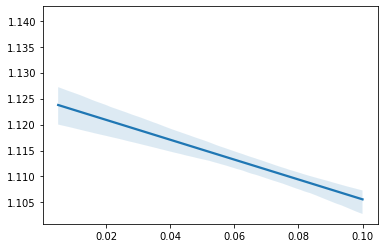

In [ ]:
fig = sns.regplot(np.array(percs), np.array(errors)[:,0], scatter_kws={'s':0})


In [ ]:
fig.set_xlabel("Percent")
fig.set_ylabel("MSE")

Text(3.200000000000003, 0.5, 'MSE')

In [ ]:
fig.figure.savefig("plot_percent1.png", dpi=300)

In [ ]:
for percent in percents[::-1]:
  for time in range(20):
    print("Time: ", time + 1)
    print()
    a,b = IPS_NB_coat(percent, train_coat_rating, sample_MCAR)
    percs.append(percent)
    errors.append([a,b])
    print('percent: ', percent)
    print('MSE: ' + str(a))

Time:  1

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [20, 40]
	-propensity scoring method: IPS
Split 6960 observations into folds. Fold sizes: [1740, 1740, 1740, 1740]
Learning on fold 0 
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.2900673525261015991
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.2396865315939876269
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.0872309874055408676
	Lambda/NumDims: (10, 40, -1, 'Regularized'), Test Fold Score: 1.1364233872154410116
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 1.1066949463750854666
	Lambda/NumDims: (25, 40, -1, 'Regularized'), Test Fold Score: 1.0745297577647688042
Learning on fold 1 
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 1.340129892315164378
	Lambda/NumDims: (1, 40, -1, 'Regularized'), Test Fold Score: 1.2594603443624658314
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 1.09296910858

In [ ]:
draw_3df = pd.DataFrame(np.array([percs, np.array(errors)[:,0], np.array(errors)[:,1]]).T, columns=["Percent", "MSE", "MAE"])

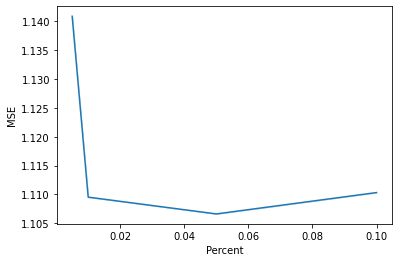

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(ax = ax,
             data = draw_3df,
             x = 'Percent',
             y = 'MSE')

In [ ]:
ax.figure.savefig("plot_percent_2.png", dpi=300)

### Yahoo R3 Dataset

#### Naive

##### Train

In [ ]:
propensities = None
propensities_desc = "naive (uniform)"
data = Files(train_yahoo_rating, propensities)

In [ ]:
lambdas = [1e-2, 1, 10]
numDims = [4, 8]
metric = MSE
raw_metric = 'MSE'

In [ ]:
completed_rating = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

In [ ]:
t_completed_rating = completed_rating[:5400,:]

##### Test

In [ ]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(test_yahoo_rating, t_completed_rating, None)[0]
  else:
    metricValue = MAE(test_yahoo_rating, t_completed_rating, None)[0]
  print(metric + ': ' + str(metricValue))

#### IPS

In [ ]:
train_yahoo_rating1 = train_yahoo_rating[:5400,:]

##### Train

In [ ]:
yahoo_user, yahoo_item = train_yahoo_rating.data.shape

In [ ]:
p = Propensity(yahoo_user, yahoo_item)

In [ ]:
p.fit(train_yahoo_rating.data, test_yahoo_rating.data)

In [ ]:
ips = p.predict(train_yahoo_rating.data)

In [ ]:
lambdas = [10]
numDims = [8]

In [ ]:
data = Files(train_yahoo_rating, ips)
metric = MSE
raw_metric = 'MSE'
propensities_desc = 'IPS'

In [ ]:
completed_rating = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric=raw_metric, output_name = completed, propensities_desc=propensities_desc)

In [ ]:
t_completed_rating = completed_rating[:5400,:]

##### Test

In [ ]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(test_yahoo_rating, t_completed_rating, None)[0]
  else:
    metricValue = MAE(test_yahoo_rating, t_completed_rating, None)[0]
  print(metric + ': ' + str(metricValue))

In [ ]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(test_yahoo_rating, t_completed_rating, None)[0]
  else:
    metricValue = MAE(test_yahoo_rating, t_completed_rating, None)[0]
  print(metric + ': ' + str(metricValue))

## 

In [ ]:
p_r_observed_coat, _ = statistic_rating(train_coat_rating.data)
p_r_coat, _ = statistic_rating(test_coat_rating.data)
p_r_observed_yahoo, _ = statistic_rating(train_yahoo_rating.data)
p_r_yahoo, _ = statistic_rating(test_yahoo_rating.data)

In [ ]:
df_draw_coat = pd.DataFrame(np.array([p_r_observed_coat, p_r_coat]).T, columns=["Train", "Test"])
df_draw_coat.index += 1
df_draw_coat.plot.bar(xlabel="Rating Values", ylabel="Propability Mass", rot=0)

In [ ]:
df_draw_yahoo = pd.DataFrame(np.array([p_r_observed_yahoo, p_r_yahoo]).T, columns=["Train", "Test"])
df_draw_yahoo.index += 1
df_draw_yahoo.plot.bar(xlabel="Rating Values", ylabel="Propability Mass", rot=0)

In [ ]:
np.sum(np.where(p_r_observed_coat != 0, p_r_observed_coat * np.log(np.array(p_r_observed_coat) / np.array(p_r_coat)), 0))

0.04903735465150651

In [ ]:
np.sum(np.where(p_r_observed_yahoo != 0, p_r_observed_yahoo * np.log(np.array(p_r_observed_yahoo) / np.array(p_r_yahoo)), 0))

0.46894871945130373

In [ ]:
dict(Counter(test_coat_rating.data.flatten()))